In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots
from collections import Counter
from matplotlib.lines import Line2D

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc
from operator import add
from tqdm.auto import tqdm
from functools import reduce
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform, pdist
from sklearn.metrics import silhouette_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, legend, add_identity

In [3]:
def mm_norm_col(column):
    return (column - column.min()) / (column.max() - column.min())

In [4]:
from matplotlib.colors import LinearSegmentedColormap
colors = ['#c7eae5','#008C8D']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmm=custom_cmap

image_ctx = {'image.cmap': 'cubehelix', 'image.interpolation': 'none'}

In [5]:
## arrange data
keep_syllables = np.loadtxt('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/to_keep_syllables_raw.txt', dtype=int)

male_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_raw_usage_matrix_v00.parquet').astype(float)
male_df = male_df[keep_syllables]

In [6]:
# avarage per age or session
m_df= male_df.groupby(['age','uuid']).mean()
avg_m_df = male_df.groupby(['age']).mean()

# normalize the data
m_norm = mm_norm_col(m_df)
avg_m_norm = mm_norm_col(avg_m_df)

In [7]:
df=m_norm

In [8]:
n_boot = 1_000
boots = []
for i in range(n_boot):
    sampled = df.groupby('age').sample(frac=1, replace=True, random_state=i)
    avg_usage = sampled.groupby("age").mean()
    smoothed_avg_usage = avg_usage.rolling(
        5, min_periods=1, win_type="gaussian", center=True
    ).mean(std=2)
    abs_diff = smoothed_avg_usage.diff().abs()
    norm_diff = np.linalg.norm(abs_diff.to_numpy(), axis=1)
    # min-max normalize
    norm_diff -= np.nanmin(norm_diff)
    norm_diff /= np.nanmax(norm_diff)

    boots.append(
        pd.Series(norm_diff, index=abs_diff.index)
    )

boot_df = pd.DataFrame(boots).T.reset_index()
boot_df = boot_df.melt(id_vars="age")

In [17]:
boot_df

,age,variable,value
0,4,0,NaN
1,8,0,0.744774
2,12,0,0.733357
3,16,0,1.000000
4,20,0,0.668993
...,...,...,...
22995,78,999,0.218839
22996,80,999,0.484121
22997,84,999,0.183557
22998,90,999,0.109229


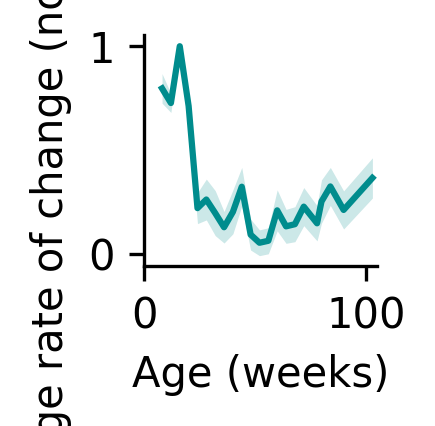

In [10]:
fig = figure(1, 1)
ax = sns.lineplot(
    data=boot_df,
    x="age",
    y="value",
    errorbar=("sd"),
    err_kws=dict(lw=0),
    color=colors[-1],
)


ax.set(xlim=(0, 105), ylabel="Usage rate of change (normalized)", xlabel="Age (weeks)")
sns.despine()


In [11]:
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig2"/ 'male_aging_rate.pdf')

In [20]:
##with jsd
m_norm.groupby('age').mean()

syllables,0,2,4,5,6,7,9,10,11,12,...,77,79,83,84,85,90,93,95,97,98
age,,,,,,,,,,,,,,,,,,,,,
4,0.165141,0.190852,0.050924,0.105755,0.122335,0.177080,0.608420,0.372866,0.599106,0.645282,...,0.040135,0.030007,0.095157,0.122666,0.642511,0.041983,0.202947,0.470289,0.034441,0.085881
8,0.219821,0.465122,0.119660,0.090237,0.324924,0.302012,0.707906,0.593203,0.606061,0.706212,...,0.223180,0.121822,0.135084,0.186418,0.459306,0.126699,0.149905,0.476096,0.134157,0.144399
12,0.243457,0.284536,0.327221,0.160765,0.334779,0.355449,0.555506,0.395519,0.414773,0.341148,...,0.388437,0.138154,0.181433,0.212834,0.274653,0.149872,0.221314,0.401013,0.153665,0.131358
16,0.249688,0.411518,0.417310,0.211501,0.370955,0.346578,0.593748,0.238589,0.326682,0.227979,...,0.324676,0.333055,0.219163,0.312135,0.236560,0.286600,0.297640,0.372760,0.482315,0.202096
20,0.271156,0.427501,0.418463,0.218594,0.433053,0.274585,0.514203,0.320952,0.338732,0.248477,...,0.303618,0.327983,0.217064,0.402386,0.150717,0.294384,0.221166,0.367526,0.405914,0.237094
24,0.233744,0.359363,0.454210,0.314099,0.151920,0.395666,0.512180,0.333462,0.265351,0.249336,...,0.201599,0.197100,0.247082,0.198006,0.187876,0.373068,0.178445,0.410066,0.243563,0.127017
28,0.180662,0.356828,0.428397,0.260126,0.353582,0.294499,0.427320,0.300933,0.227448,0.173170,...,0.251478,0.308111,0.273572,0.295880,0.160494,0.317849,0.280325,0.328250,0.364715,0.238881
32,0.301597,0.402327,0.354512,0.328013,0.197366,0.346752,0.474292,0.148404,0.357999,0.232205,...,0.356247,0.243990,0.209182,0.220298,0.237908,0.326402,0.326129,0.517205,0.234520,0.178421
36,0.256682,0.311352,0.379024,0.354621,0.151836,0.405366,0.415420,0.265525,0.151185,0.178184,...,0.267861,0.368639,0.367345,0.216553,0.219240,0.383518,0.210691,0.263363,0.296470,0.188077


In [27]:
dists = squareform(pdist(avg_m_norm, metric='jensenshannon'))
diagonal_above_main = np.diag(dists, k=1)
print(dists)
print ('sss')
print(diagonal_above_main)

[[0.         0.39743207 0.40472789 0.50604689 0.5189346  0.48821467
  0.56641542 0.48097018 0.56384319 0.57079015 0.54525107 0.59734919
  0.54952955 0.52333428 0.5970921  0.56506256 0.61711448 0.522186
  0.54884246 0.50125315 0.59715476 0.54661772 0.70108202]
 [0.39743207 0.         0.23748912 0.28003097 0.29543079 0.30492275
  0.36949631 0.31405321 0.39214216 0.36919908 0.39641624 0.43916932
  0.48553057 0.3682705  0.446748   0.46390024 0.4441609  0.43719116
  0.43386965 0.40483977 0.49508785 0.46003051 0.62914719]
 [0.40472789 0.23748912 0.         0.21177137 0.22570542 0.18521188
  0.28506507 0.19659562 0.27704862 0.25720342 0.27477293 0.32936722
  0.34816115 0.23272443 0.32969742 0.33212886 0.33720934 0.32324193
  0.30646514 0.27817065 0.38578835 0.33393755 0.52868495]
 [0.50604689 0.28003097 0.21177137 0.         0.11830038 0.22111868
  0.21294303 0.20062446 0.24929222 0.20223391 0.25165915 0.31631794
  0.42086013 0.22046654 0.29914983 0.37840974 0.2900545  0.35587295
  0.34891716